# Analyses of syllables

In [6]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [ ]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from postprocessing_functions import transition_probabilities
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_wheel_02-16-2026')

In [61]:
identifiable_mapping = {}
counter = 0
for wheel in [0, 1, 2]:
    for lick in [0, 1]:
        for whisk in [0, 1]:
            for paw in range(8):
                key = f"{paw}{whisk}{lick}{wheel}"
                identifiable_mapping[key] = float(counter)
                counter += 1

identifiable_mapping["nan"] = np.nan
paw_fix_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}
wheel_fix_mapping = {0:1, 1:0, 2:2} 

inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

In [37]:
states_oder = ['']*96
counter = 0
for wheel in [0, 1, 2]:
    for lick in [0, 1]:
        for whisk in [0, 1]:
            for paw in range(8):
                key = f"{paw}{whisk}{lick}{wheel}"
                states_oder[counter] = str(key)
                counter += 1

## Unique states use

In [8]:
unique_states = states_file[['mouse_name', 'session', 'identifiable_states']].drop_duplicates()

In [9]:
unique_states_count = pd.DataFrame(unique_states.groupby(['identifiable_states', 'session'])['identifiable_states'].count())
unique_states_count = unique_states_count.rename(columns={"identifiable_states": "count"}).reset_index()
unique_states_count = pd.DataFrame(unique_states_count.groupby(['identifiable_states'])['count'].sum()).reset_index()
unique_states_count['ratio'] = unique_states_count['count'] / len(states_file['session'].unique())

In [50]:
base_pal = ListedColormap(sns.color_palette('Set2', 8))
palette = [base_pal(i) for i in range(base_pal.N)]*12  # Extract colors properly


/tmp/ipykernel_52484/3426793176.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='identifiable_states', y='count', data=unique_states_count, order=states_oder, palette=state_to_color)
/tmp/ipykernel_52484/3426793176.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))


Text(0.5, 0, 'Syllables')

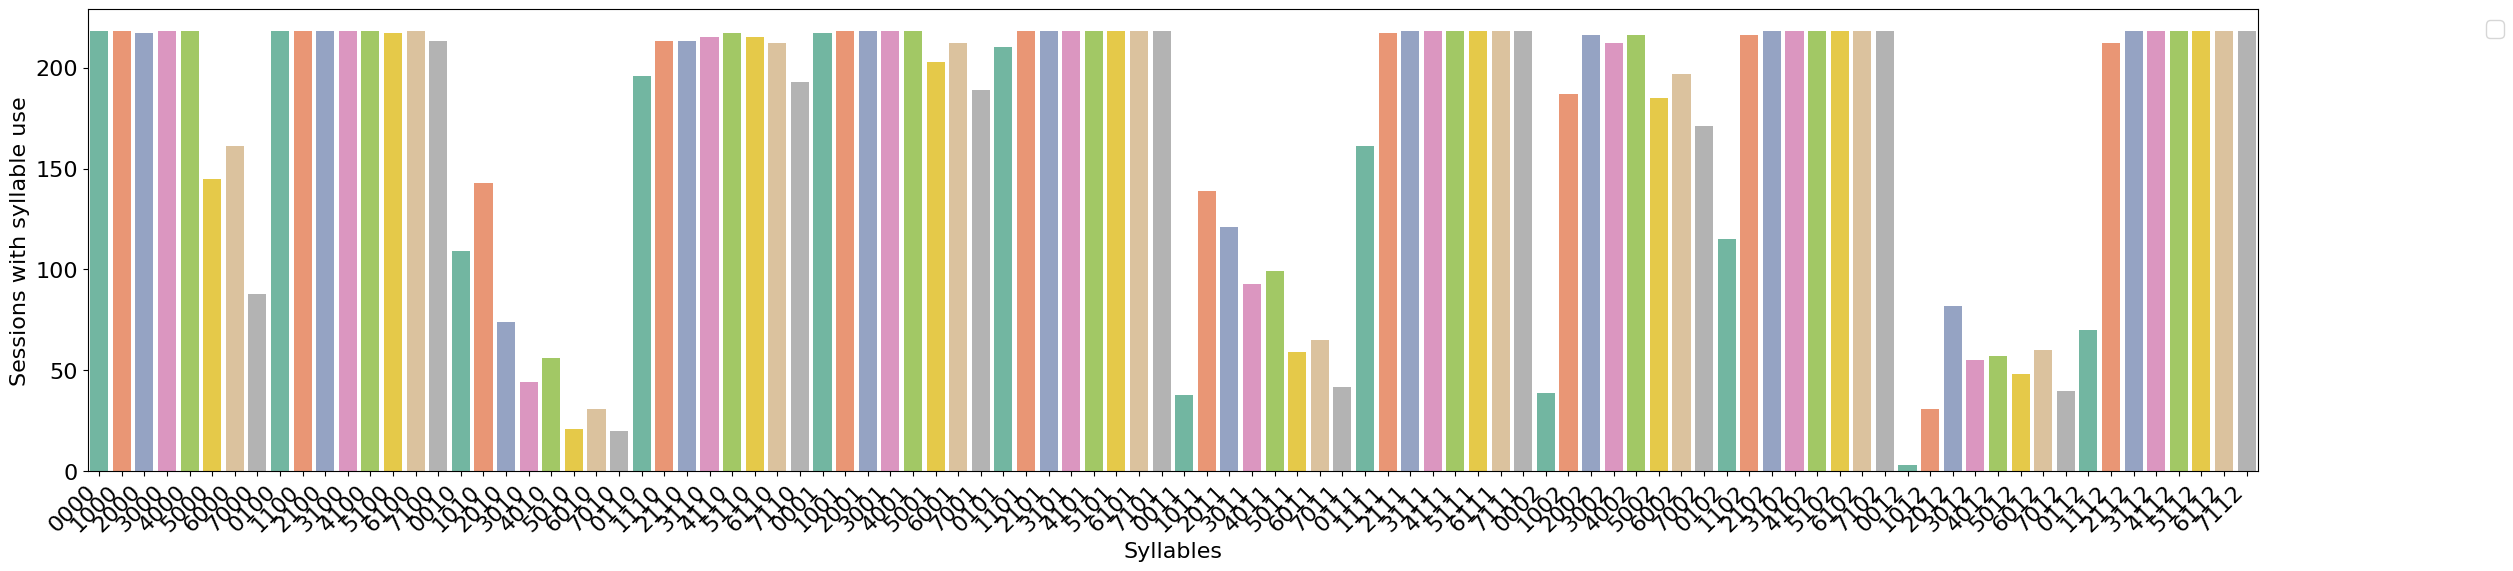

In [52]:
palette_16 = create_grouped_gradient_palette(n_groups=8, shades_per_group=12, base_palette='Set2')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(states_oder, palette))
plt.figure(figsize=[28, 6])
plt.rc('font', size=16)

sns.barplot(x='identifiable_states', y='count', data=unique_states_count, order=states_oder, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Sessions with syllable use')
plt.xlabel('Syllables')


/tmp/ipykernel_52484/2637515480.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='identifiable_states', y='fraction',  data=fractions, order=states_oder, palette=state_to_color)
/tmp/ipykernel_52484/2637515480.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))


Text(0.5, 0, 'Syllables')

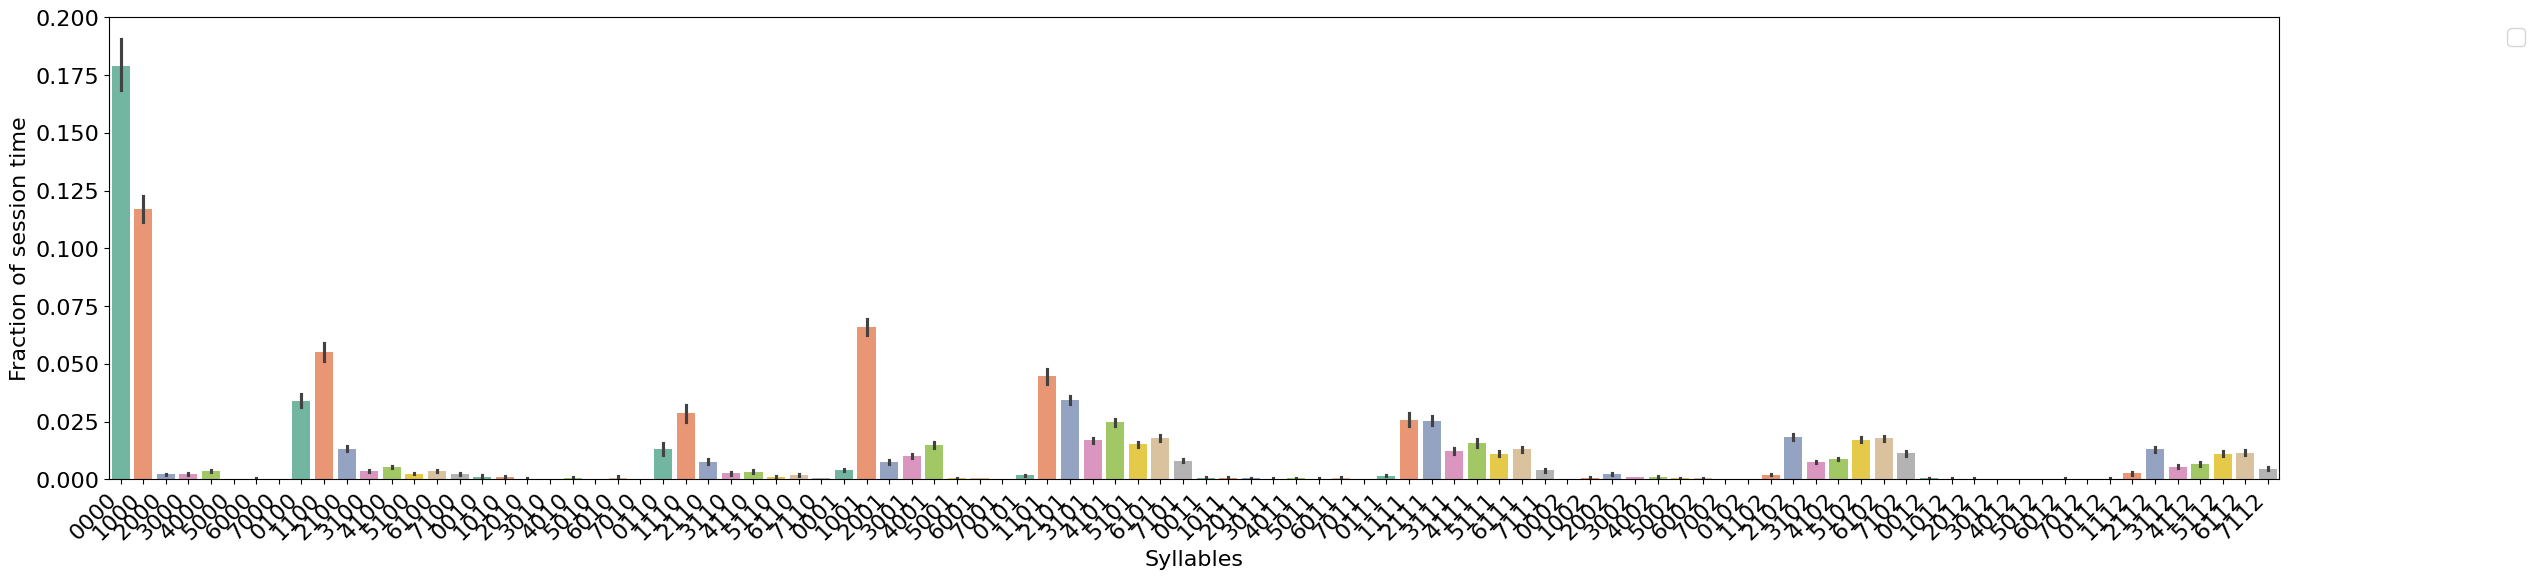

In [54]:
fractions = states_file.groupby(['session'])['identifiable_states'].value_counts(normalize=True).rename('fraction').reset_index()

state_to_color = dict(zip(states_oder, palette))
plt.figure(figsize=[28, 6])
plt.rc('font', size=16)

sns.barplot(x='identifiable_states', y='fraction',  data=fractions, order=states_oder, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Fraction of session time')
plt.xlabel('Syllables')

Text(0.5, 0, 'Syllables')

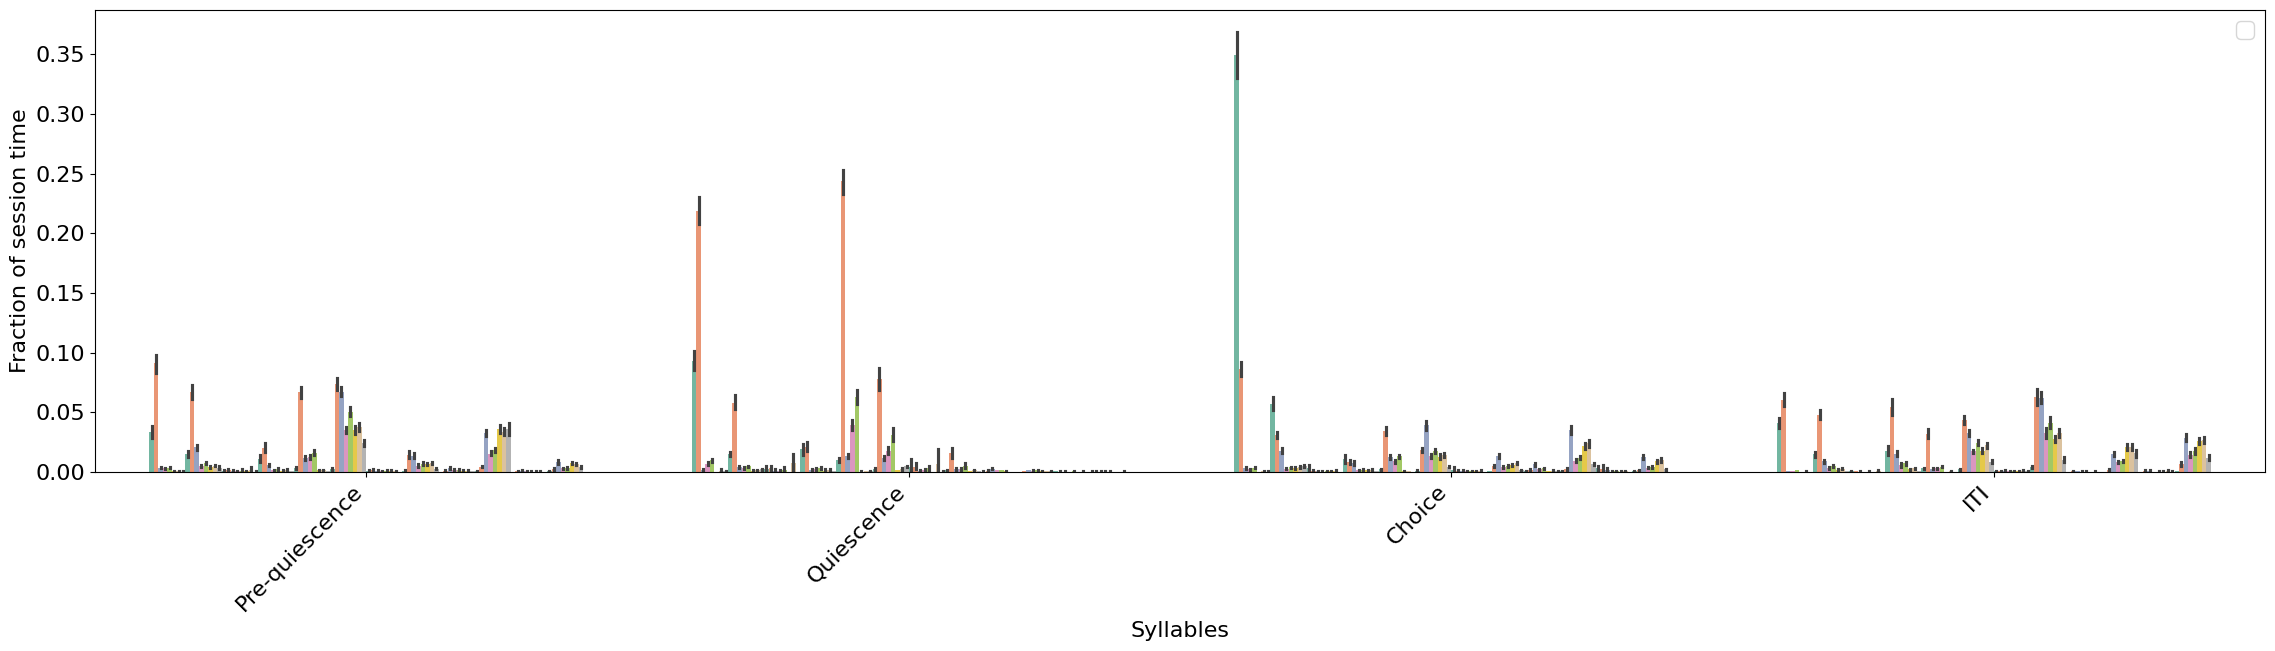

In [56]:
fractions = states_file.groupby(['session', 'broader_label'])['identifiable_states'].value_counts(normalize=True).rename('fraction').reset_index()

state_to_color = dict(zip(states_oder, palette))
plt.figure(figsize=[28, 6])

sns.barplot(hue='identifiable_states', y='fraction', x='broader_label', data=fractions, order=['Pre-quiescence',
                                                                                               'Quiescence', 'Choice', 'ITI'],hue_order=states_oder, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.legend('')
plt.ylabel('Fraction of session time')
plt.xlabel('Syllables')

## State dwell time and transition matrix

In [87]:
sessions = states_file.session.unique()

group_state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_states', 'median_duration', 'mean_duration', 'trans_mat'])
group_trans_mat = pd.DataFrame(columns=['mouse_name', 'session', 'trans_mat'], index=range(len(sessions)))

for m, session in enumerate(sessions):

    session_states = states_file.loc[states_file['session']==session]
    mouse_name = list(session_states['mouse_name'])[0]
    new_states = np.array(session_states['most_likely_states'])
    num_states = len(np.unique(new_states))
    all_identifiable_states = states_oder.copy()
            
    """ State statistics """
    state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_states',
                                        'median_duration', 'mean_duration'], index=range(len(all_identifiable_states))) 
    
    state_freq['mouse_name'] = mouse_name
    state_freq['session'] = session
    state_freq['identifiable_states'] = all_identifiable_states

    # State for which we have the durations
    dif = np.diff(new_states)
    jump = np.where(dif != 0)
    jump_dif = np.diff(jump)
    median = np.nanmedian(jump_dif)

    state_names = new_states[jump][1:]
    unique_states = np.array(list(inverted_mapping.keys()))
    unique_states = unique_states[~np.isnan(unique_states)]
    replace_func = np.vectorize(inverted_mapping.get)
    state_label = replace_func(unique_states)

    for s, st in enumerate(unique_states):
        state_durations = jump_dif[0][np.where(state_names==st)]
        state_freq.loc[state_freq['identifiable_states']==state_label[s], 'median_duration'] = np.median(state_durations)
        state_freq.loc[state_freq['identifiable_states']==state_label[s], 'mean_duration'] = np.mean(state_durations)
    
    # sns.barplot(x='identifiable_states', y='median_duration', data=state_freq, order=state_label, palette=state_to_color)
    # plt.xticks(rotation=45, ha='right')
    # plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    # plt.ylabel('Median dwell time (s)')
    # plt.xlabel('Syllables')
    # plt.show()

    # Save to big df
    if len(group_state_freq) == 0:
        group_state_freq = state_freq.copy()
    else:
        group_state_freq = pd.concat([group_state_freq, state_freq])
                        
    """ State transition matrix (empirical) """
    transition_matrix = transition_probabilities(new_states, unique_states)
    # plt.imshow(transition_matrix)
    # plt.xlabel('Current state')
    # plt.ylabel('Previous state')
    # plt.xticks(np.arange(0, len(all_identifiable_states)), state_label)
    # plt.yticks(np.arange(0, len(all_identifiable_states)), state_label)
    # plt.xticks(rotation=45, ha='right')
    # plt.show()
    group_trans_mat['mouse_name'][m] = mouse_name
    group_trans_mat['session'][m] = session
    # group_trans_mat['trans_mat'][m] = trans_mat_complete(identifiable_mapping, state_label, unique_states, transition_matrix)
    group_trans_mat['trans_mat'][m] = transition_matrix

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/numpy/_co

Text(46.722222222222214, 0.5, 'Previous state')

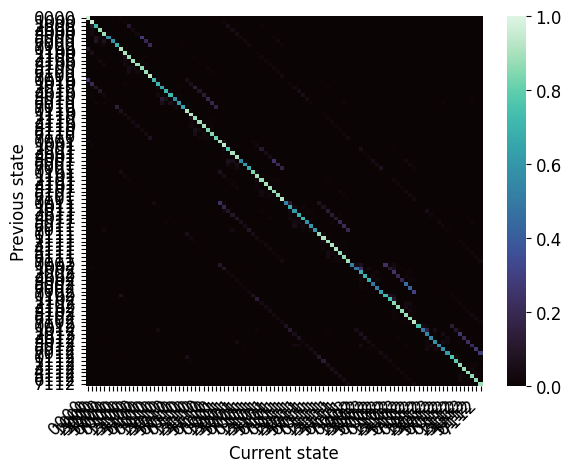

In [88]:
# Results on original model
plt.rc('font', size=12) 
# plt.figure(figsize=[9, 8])
hmap = sns.color_palette("mako", as_cmap=True)
stacked_matrices = np.stack(group_trans_mat['trans_mat'].dropna().values)
nanmean_matrix = np.nanmean(stacked_matrices, axis=0)
sns.heatmap(nanmean_matrix, annot=False, fmt='.1f',
    yticklabels=states_oder, xticklabels=states_oder, 
    cmap= hmap, vmin=0, vmax=1) 
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('Current state')
plt.ylabel('Previous state')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


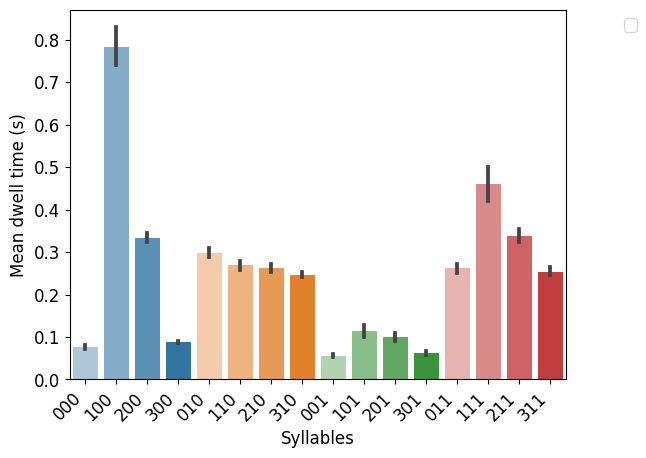

In [ ]:
sns.barplot(x='identifiable_states', y='mean_duration', data=group_state_freq, order=state_label, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Mean dwell time (s)')
plt.xlabel('Syllables')
plt.show()